# Quick visualisation and analysis of Sentinel 2 data over Ghana
### J Gómez-Dans (NCEO & UCL)

This notebooks presents a quick way to extract and analyse data from Sentinel 2. This is just a demo that highlights a limited regional extent around Tamale (Northern Ghana), but this could be extended to other areas.

The notebooks shows how the user can select a region of interest (ROI) online, using e.g. [GeoJSON.io](https://geojson.io), or [Google My Maps](https://www.google.com/mymaps), or any other way you want. You will then extract all the data that pertains to that region of interest and you can play around with it in normal Python.

Note that all the data is being accessed remotely, so it can take a little while for the code to complete. However, note that you are only downloading the bits that you require to process your data! It's around 150Gb of raw data that needs downloading and processing!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import gdal
gdal.UseExceptions()   

from utils import grab_holdings, extract_roi_data_ndre

img_db = grab_holdings()

In [2]:
roi="https://gist.github.com/jgomezdans/d2c80bc049b7fa8822c47236674ddea8/" + \
    "raw/9a0d697adbc244b26d140d3a7c524d0f2857336b/map.geojson"
analysis_data = extract_roi_data_ndre(img_db, roi=roi)

There is data for 02 January 2018


/home/ucfajlg/python/demo_ghana/utils.py:34: RuntimeWarning: Mean of empty slice
  if not np.isnan(np.nanmean(data1)):


There is data for 12 January 2018
There is data for 22 January 2018
There is data for 01 February 2018
There is data for 03 March 2018
There is data for 13 March 2018
There is data for 12 April 2018
There is data for 22 April 2018
There is data for 22 May 2018
There is data for 11 June 2018
There is data for 11 July 2018
There is data for 10 August 2018
There is data for 30 August 2018
There is data for 29 September 2018
There is data for 19 October 2018
There is data for 28 November 2018
There is data for 08 December 2018
There is data for 18 December 2018
There is data for 28 December 2018
There is data for 07 January 2019
There is data for 17 January 2019


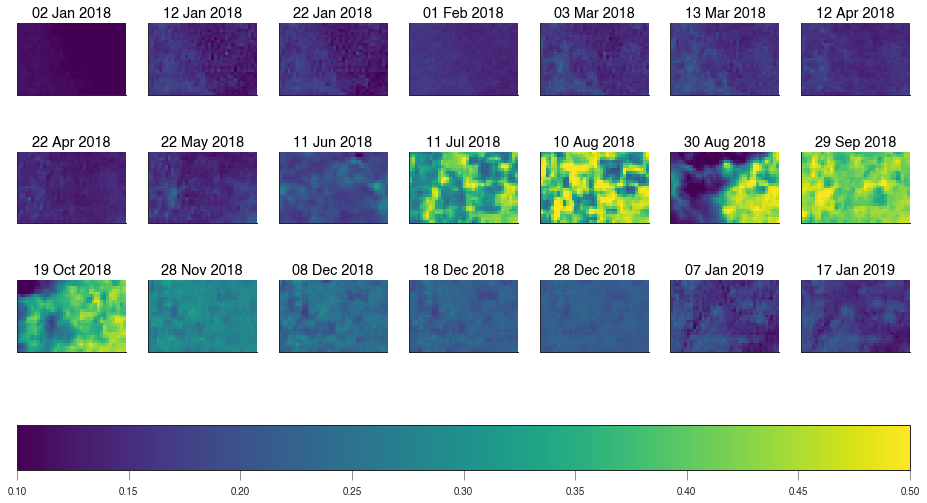

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=7, sharex=True, sharey=True, figsize=(16,9))
axs = axs.flatten()
for ii, (k,v) in enumerate(analysis_data.items()):
    im =axs[ii].imshow(v, interpolation="nearest", vmin=0.1, vmax=0.5, cmap=plt.cm.viridis)
    axs[ii].set_title(k.strftime("%d %b %Y"))
    axs[ii].set_xticks([])
    axs[ii].set_yticks([])

fig.colorbar(im, ax=axs.tolist(), orientation="horizontal")



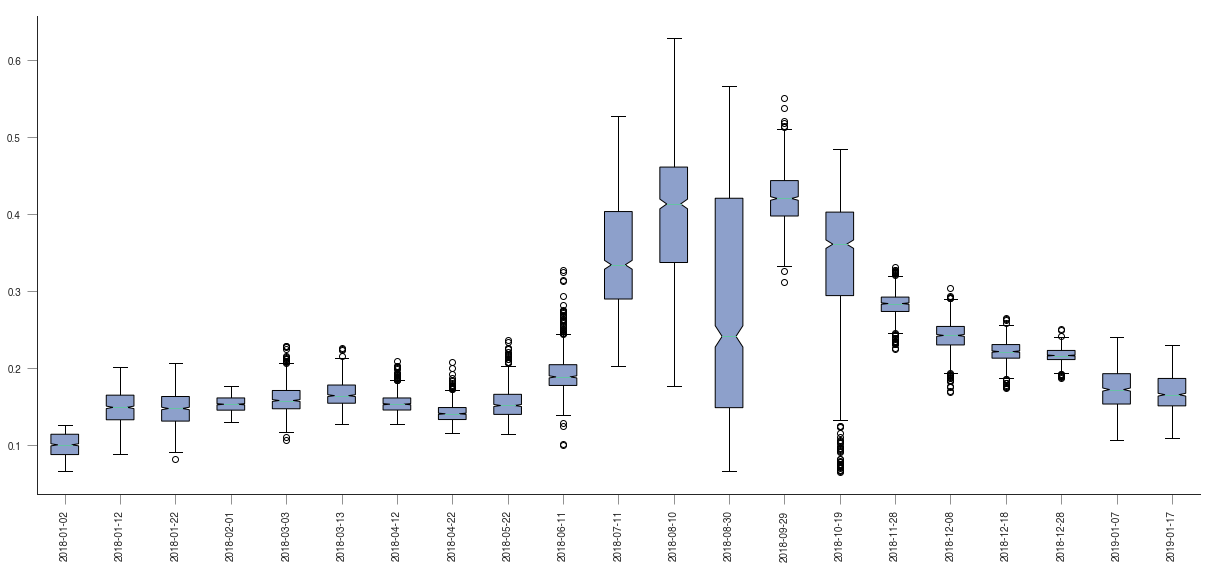

In [4]:
data = []
tx = []
for ii, (k,v) in enumerate(analysis_data.items()):
    tx.append(k)
    data.append(v.flatten())
plt.figure(figsize=(17,8))    
bp = plt.boxplot(data, notch=True, meanline=True, patch_artist=True, labels=tx)
_ = plt.xticks(rotation="vertical")
_ = [patch.set_facecolor("#8DA0CB") for patch in bp['boxes']]
plt.tight_layout()